<a href="https://colab.research.google.com/github/vkth7/AIFFEL-exploration/blob/main/exp-15/%5Bexp-15%5D%20%EB%8B%A4%EC%96%91%ED%95%9C%20OCR%EB%AA%A8%EB%8D%B8%20%EB%B9%84%EA%B5%90%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

우리는 지금까지 Google OCR API, keras-ocr, Tesseract 이상 3가지의 OCR 기능을 간단히 활용하여 보았습니다.

지금까지 살펴본 바로는 무료로 사용할 수 있는 기능들이지만 모두 준수한 성능을 갖추고 있었습니다. OCR 분야가 이미 실용적인 수준에까지 기술이 발전했기 때문에 이런 것들만 잘 활용해도 실전에 활용할 수 있는 좋은 서비스를 만들어 낼 수 있을 것도 같습니다. 그런데 과연 어떤 것을 사용하는 것이 좋을까요?

OCR 기술들이 실용적인 수준까지 꽤 발전했지만 그럼에도 불구하고 아직 완전한 수준은 아닙니다. 용도에 맞게 적절한 것을 선택하는 것도 중요한 일입니다. 그래서 오늘 다뤄본 위 3가지를 검증해 보는 프로젝트를 진행하겠습니다. 여러분은 OCR 기능을 활용한 서비스를 빠르게 개발해야 하는 임무를 맡은 엔지니어가 되어, 어떤 모듈을 도입하면 좋을지 기술검증을 하는 역할을 맡게 되었다고 가정합니다.

- 사진을 찍어 간판에 적힌 글을 지도와 연동해 주소를 알려주거나 음식점을 찾아주는 서비스에 ocr 사용

In [1]:
# colab용 라이브러리 설치
# !pip install google-api-python-client google-cloud-vision
# !pip install keras_ocr matplotlib==3.3.0
# !apt install tesseract-ocr
# !apt install libtesseract-dev
# !pip install pytesseract

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

from google.cloud import vision
import io

import keras_ocr
import cv2

import os
import pytesseract
from PIL import Image
from pytesseract import Output

import glob

## Step1. 검증용 데이터셋 준비
---
<br>

OCR 관련해서 오늘 다루어본 주제는 텍스트의 모양과 크기, 배치, 노이즈 등 OCR의 성능에 영향을 미치는 요인들에 관한 것이었습니다. 여러분들은 위 3가지 기능들이 이미지에 나타난 특징에 따라 얼마나 정확하게 문자를 detect하고 recognize하는지를 검증하기 위한 이미지 데이터를 모아야 합니다. 이미지가 많을수록 좋겠지만 검증해야 할 항목별로 고루 갖춰지는 것도 중요합니다.
<br><br>
가능하다면 함께 학습하는 동료들과 힘을 합쳐보는 것을 추천합니다. 그렇다고 너무 많은 이미지 데이터로 검증하는 것은 이후 결과를 정리하는 것이 힘들 수 있으니 테스트용 이미지는 아무리 많아도 20장을 넘기지 않는 것으로 합시다.

In [3]:
def get_img_path_n_file_list(work_dir, img_ext='.jpg'):
  img_path_list = [img_path for img_path in glob.glob(work_dir + '/*') if img_path.endswith(img_ext)]
  img_file_list = [img_file for img_file in os.listdir(work_dir) if img_file.endswith(img_ext)]
  return img_path_list, img_file_list

In [4]:
work_dir = 'drive/MyDrive/aiffel/exp15'
img_path_list, img_file_list = get_img_path_n_file_list(work_dir)

In [5]:
img_path_list.sort()
img_path_list

['drive/MyDrive/aiffel/exp15/bbiddac-volbATNCO8E-unsplash.jpg',
 'drive/MyDrive/aiffel/exp15/clem-onojeghuo-NT3qP7WbmzE-unsplash.jpg',
 'drive/MyDrive/aiffel/exp15/kate-kopteva-dpkwzjadrCQ-unsplash.jpg',
 'drive/MyDrive/aiffel/exp15/nagara-oyodo-XPO6jJdQDAY-unsplash.jpg',
 'drive/MyDrive/aiffel/exp15/waranont-joe-TWx30RufoFk-unsplash.jpg']

In [6]:
img_file_list.sort()
img_file_list

['bbiddac-volbATNCO8E-unsplash.jpg',
 'clem-onojeghuo-NT3qP7WbmzE-unsplash.jpg',
 'kate-kopteva-dpkwzjadrCQ-unsplash.jpg',
 'nagara-oyodo-XPO6jJdQDAY-unsplash.jpg',
 'waranont-joe-TWx30RufoFk-unsplash.jpg']

## Step2. keras-ocr, Tesseract로 테스트 진행(Google OCR API는 선택 사항)
---
<br>

위 두 가지 모듈을 활용하는 방법에 대해서는 코드 레벨로 이미 경험해 보셨을 것입니다. 이미지 리스트를 정리한 후 반복문을 실행하며 모듈이 출력한 결과를 모아 봅시다. 가능하다면 Google OCR API를 포함해 세 가지 모듈을 다 써보세요.

### keras-ocr

In [7]:
# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5


In [8]:
images = [keras_ocr.tools.read(img_path) for img_path in img_path_list]
prediction_groups = [pipeline.recognize([img_path]) for img_path in img_path_list]

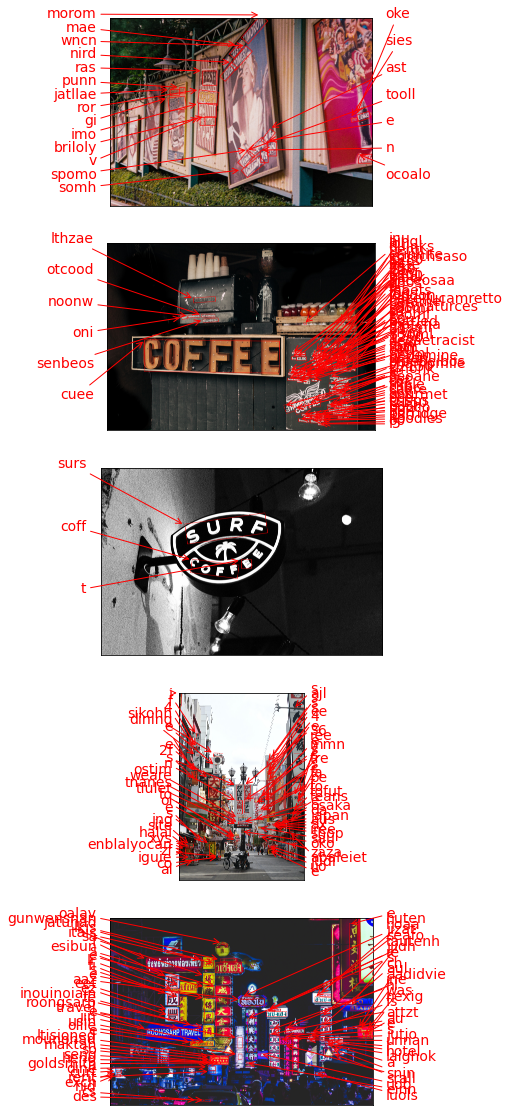

In [9]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

In [10]:
keras_ocr_dict = {}
for idx, img_path in enumerate(img_path_list):
  keras_ocr_dict[img_path] = prediction_groups[idx][0]

In [11]:
keras_ocr_dict

{'drive/MyDrive/aiffel/exp15/bbiddac-volbATNCO8E-unsplash.jpg': [('morom',
   array([[1632.0319  ,  -34.41572 ],
          [1709.6351  ,   31.248692],
          [1499.9738  ,  279.03055 ],
          [1422.3702  ,  213.36613 ]], dtype=float32)),
  ('mae', array([[1380.6476 ,  290.92056],
          [1431.8282 ,  336.07993],
          [1344.1085 ,  435.4955 ],
          [1292.9279 ,  390.33618]], dtype=float32)),
  ('wncn', array([[1473.6517 ,  300.68027],
          [1542.0647 ,  360.71628],
          [1360.4363 ,  567.6883 ],
          [1292.0232 ,  507.65228]], dtype=float32)),
  ('nird', array([[1320.256  ,  481.48752],
          [1380.3994 ,  533.4296 ],
          [1249.2925 ,  685.23773],
          [1189.149  ,  633.2956 ]], dtype=float32)),
  ('ras', array([[1004.7363 ,  573.33984],
          [1157.8125 ,  573.33984],
          [1157.8125 ,  729.1992 ],
          [1004.7363 ,  729.1992 ]], dtype=float32)),
  ('punn', array([[754.24805, 751.46484],
          [815.4785 , 751.46484],
 

### Tesseract

In [12]:
# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output', lang='eng'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang=lang,    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_dict = {}
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            img_file = img_path.split('/')[-1][:-4]
            output_img_path = os.path.join(output_path, f"{img_file + '_' + str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_dict[output_img_path] = [(left, top), (left+width, top), (left+width, top+height), (left, top+height)]
            index += 1
    return cropped_image_dict

work_dir_eng = 'drive/MyDrive/aiffel/exp15/eng'
work_dir_kor = 'drive/MyDrive/aiffel/exp15/kor'
output_dir = work_dir + '/tesseract_output'

In [13]:
def recognize_images(cropped_image_path_list, lang='eng'):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    text_list = []
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang=lang,    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        text = recognized_data['text']
        print(text)
        text_list.append(text)
    print("Done")

    return text_list

In [14]:
img_path_list_eng, img_file_list_eng = get_img_path_n_file_list(work_dir_eng)
img_path_list_kor, img_file_list_kor = get_img_path_n_file_list(work_dir_kor)

In [15]:
tesseract_ocr_dict = {}
for img_path, img_file in zip(img_path_list_eng, img_file_list_eng):
    print(f'---------------{img_file}---------------')
    cropped_image_dict = crop_word_regions(img_path, output_dir)
    
    # 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
    text_list = recognize_images(cropped_image_dict.keys())
    tesseract_ocr_dict[img_file] = {'text_list': text_list, 'cropped_image_dict': cropped_image_dict}

---------------clem-onojeghuo-NT3qP7WbmzE-unsplash.jpg---------------
drive/MyDrive/aiffel/exp15/tesseract_output/clem-onojeghuo-NT3qP7WbmzE-unsplash_0000.png
drive/MyDrive/aiffel/exp15/tesseract_output/clem-onojeghuo-NT3qP7WbmzE-unsplash_0001.png


Done
---------------bbiddac-volbATNCO8E-unsplash.jpg---------------
drive/MyDrive/aiffel/exp15/tesseract_output/bbiddac-volbATNCO8E-unsplash_0000.png

Done


In [16]:
tesseract_ocr_dict

{'clem-onojeghuo-NT3qP7WbmzE-unsplash.jpg': {'text_list': ['\x0c', '\x0c'],
  'cropped_image_dict': {'drive/MyDrive/aiffel/exp15/tesseract_output/clem-onojeghuo-NT3qP7WbmzE-unsplash_0000.png': [(3426,
     1989),
    (3432, 1989),
    (3432, 2674),
    (3426, 2674)],
   'drive/MyDrive/aiffel/exp15/tesseract_output/clem-onojeghuo-NT3qP7WbmzE-unsplash_0001.png': [(464,
     125),
    (5122, 125),
    (5122, 3584),
    (464, 3584)]}},
 'bbiddac-volbATNCO8E-unsplash.jpg': {'text_list': ['\x0c'],
  'cropped_image_dict': {'drive/MyDrive/aiffel/exp15/tesseract_output/bbiddac-volbATNCO8E-unsplash_0000.png': [(0,
     0),
    (2850, 0),
    (2850, 2036),
    (0, 2036)]}}}

In [17]:
tesseract_ocr_text_pos_list = []
tesseract_ocr_text_list = []
for i, (img_path, tesseract_ocr_result) in enumerate(tesseract_ocr_dict.items()):
  tesseract_ocr_text_list.append([i, tesseract_ocr_result['text_list']])
  tesseract_ocr_text_pos_list.append([i, list(tesseract_ocr_result['cropped_image_dict'].values())])

In [18]:
tesseract_ocr_text_pos_list

[[0,
  [[(3426, 1989), (3432, 1989), (3432, 2674), (3426, 2674)],
   [(464, 125), (5122, 125), (5122, 3584), (464, 3584)]]],
 [1, [[(0, 0), (2850, 0), (2850, 2036), (0, 2036)]]]]

In [19]:
tesseract_ocr_text_list

[[0, ['\x0c', '\x0c']], [1, ['\x0c']]]

IndexError: ignored

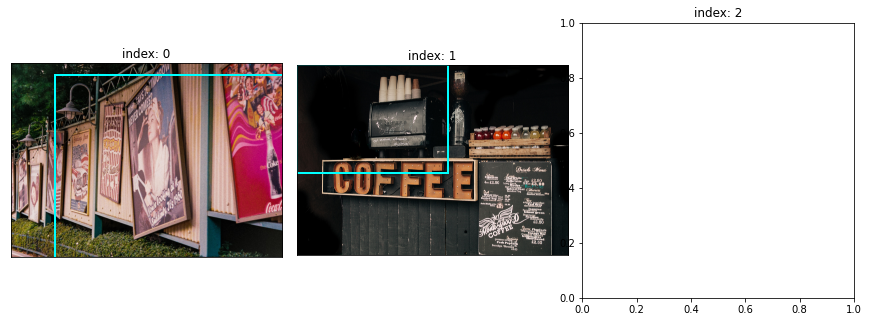

In [21]:
plt.figure(figsize=(20,20))

for i, img_path in enumerate(img_path_list):
    plt.subplot(5, 5, i+1)
    plt.title(f'index: {i}')
    
    text_pos_list = tesseract_ocr_text_pos_list[i][1]
    text_list = tesseract_ocr_text_list[i][1]
    text = ', '.join(text_list)

    for text_pos in text_pos_list:
        w = text_pos[2][0]-text_pos[0][0]
        h = text_pos[2][1]-text_pos[0][1]
        rect = patches.Rectangle(
            (text_pos[0]),
            w, h,
            linewidth=2,
            edgecolor='cyan',
            fill=False
        )
        plt.gca().add_patch(rect)

    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    plt.imshow(img_rgb)

    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

    plt.tight_layout()

plt.show()

## Step4. 결과 분석과 결론 제시
---
<br>

우선 여러분들이 구현하고자 하는 서비스의 목적과 내용을 먼저 정리합니다. 여러분들이 검토한 OCR 모델들이 그 목적에 부합하는지 확인하기 위해 필요한 평가 기준을 제시합니다. 그 기준에 따라 위에서 정리한 테스트 결과를 분석하여 가장 나은 대안의 모델을 선정합니다.

테서렉트를 이용해 검출을 하려 했으나 제대로 검출이 되지 않아 keras-ocr과 비교를 할 수 없었습니다.

이를 통해 테서렉트의 성능의 신뢰도가 떨어져 테서렉트를 사용하지 않고 영어로 된 글자가 있는 사진에서 keras-ocr을 이용하면 대부분의 경우 잘 작동될 것으로 예상되어 keras-ocr을 선택할 것입니다.

루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

평가문항	상세기준
1. OCR을 활용하여 구현하려는 서비스의 기획이 타당한가?

  - 기획한 서비스가 OCR 적용 가능한 서비스이며, OCR 기술을 활용했을 때 더 유용한지에 대한 타당성 여부를 기술하였다.

2. 모델 평가기준이 명확하고 체계적으로 세워졌는가?

  - 앞서 기획한 서비스에서 OCR 모델들이 그 목적에 부합하는지 확인하기 위해 필요한 평가 기준을 제시하고, 평가기준에 적합한 테스트 데이터의 특징이 무엇인지 설명하였다.

3. 평가기준에 따라 충분한 분량의 테스트가 진행되고 그 결과가 잘 정리되었는가?

  - 최대 20장까지의 테스트 이미지를 사용해 제시된 평가 기준에 따른 테스트 결과가 잘 정리되어 결론이 도출되었다.

# 회고
- 이번 프로젝트에서 어려웠던 점
  - 테서렉트를 사용할 때 나온 오류를 못잡았습니다